In [ ]:
! pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.4 MB/s eta 0:00:0000:0100:01


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV


random.seed(42)

/opt/conda/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
df_all = pd.read_csv('~/work/project/clean_df.csv')
df_all['time_close'] = pd.to_datetime(df_all['time_close'])
# df_all = df_all.loc[df_all['time_close'] > '2021-07-01']
df = df_all.loc[df_all['symbol_id'] == 'LTC_2'].copy().reset_index(drop=True)
symbols = ['DOGE_74', 'ETH_1027', 'XRP_52', 'XLM_512', 'BTC_1', 'XMR_328']
for sym in symbols:
    df[sym] = df_all.loc[df_all['symbol_id'] ==  sym]['close'].values
    df[(sym + ' change')] = df_all.loc[df_all['symbol_id'] ==  sym]['price change'].values
df.drop(columns=['symbol_id'], inplace=True)
df.head()

,time_close,close,volume,marketcap,month,day,weekday,day of week,price change,volume change,...,ETH_1027,ETH_1027 change,XRP_52,XRP_52 change,XLM_512,XLM_512 change,BTC_1,BTC_1 change,XMR_328,XMR_328 change
0,2020-09-24,43.575650,1.723047e+09,2.855191e+09,9,24,3,1,-0.021570,-0.030759,...,322.801017,-0.059389,0.222924,-0.045198,0.068613,-0.041776,10295.054804,-0.021312,88.404357,-0.051886
1,2020-09-25,44.790372,2.027335e+09,2.935124e+09,9,25,4,1,0.027876,0.176599,...,348.029329,0.078154,0.231864,0.040102,0.070204,0.023188,10773.534000,0.046477,91.695987,0.037234
2,2020-09-26,46.090238,1.852828e+09,3.020641e+09,9,26,5,0,0.029021,-0.086077,...,351.552190,0.010122,0.243233,0.049036,0.074894,0.066801,10668.141934,-0.009782,93.026053,0.014505
3,2020-09-27,46.340146,2.191838e+09,3.037367e+09,9,27,6,0,0.005422,0.182969,...,359.182175,0.021704,0.243122,-0.000456,0.074085,-0.010805,10769.604523,0.009511,95.044383,0.021696
4,2020-09-28,46.434781,2.217909e+09,3.043916e+09,9,28,0,1,0.002042,0.011895,...,358.283277,-0.002503,0.244379,0.005170,0.074022,-0.000851,10881.984006,0.010435,97.741001,0.028372


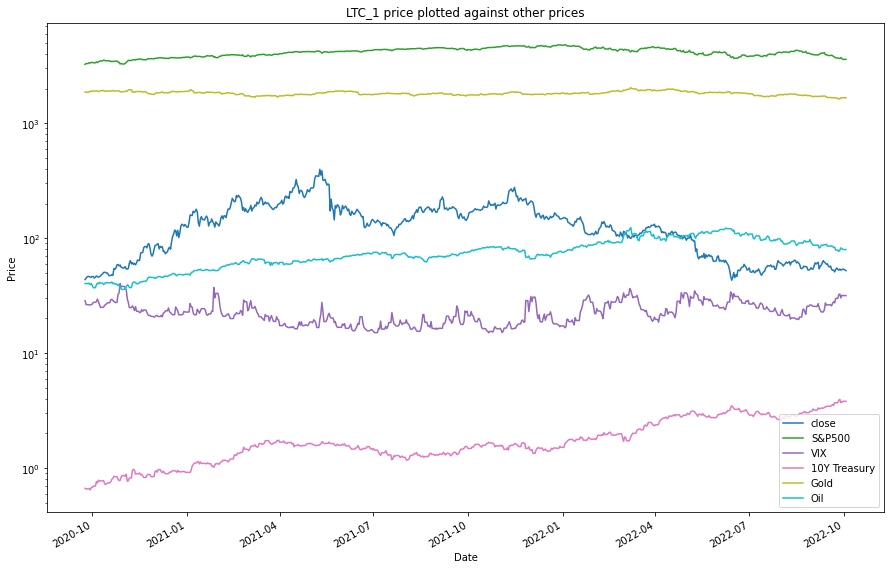

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
df.plot(x='time_close', y=['close','S&P500', 'VIX', '10Y Treasury', 'Gold', 'Oil'], 
        logy=True, figsize=(15, 10),
        cmap = 'tab10', ax = ax)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('LTC_1 price plotted against other prices')
plt.show()

In [ ]:
col = 'tomorrow change'
timeseries = df[col]
result = adfuller(timeseries)
print(f'ADF Statistic: {result[0]:.3f}')
print(f'p-value: {result[1]:.3E}')
if result[0] > result[4]["5%"]:
    conclusion=f"Failed to Reject H_0 at 5% -> {col} Time Series is Non-Stationary"
else:
    conclusion=f"Reject H_0 at at 5% -> {col} Time Series is Stationary"
print(conclusion)

ADF Statistic: -8.281
p-value: 4.516E-13
Reject H_0 at at 5% -> tomorrow change Time Series is Stationary


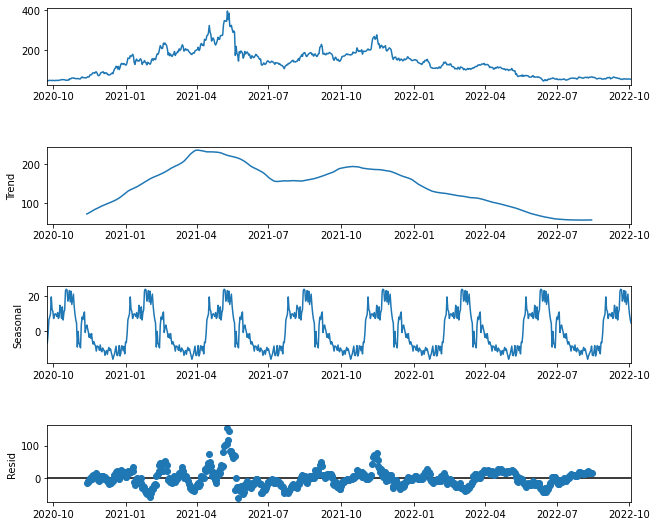

In [8]:
df_close = df[['time_close', 'close']].copy()
df_close = df_close.set_index('time_close')
df_close.head()

decomp = sm.tsa.seasonal_decompose(df_close, period=100)
fig = decomp.plot()
fig.set_size_inches(10, 8)

In [7]:
df['EMA_9'] = df['close'].ewm(9).mean().shift()
df['SMA_10'] = df['close'].rolling(10).mean().shift()
df['SMA_30'] = df['close'].rolling(30).mean().shift()

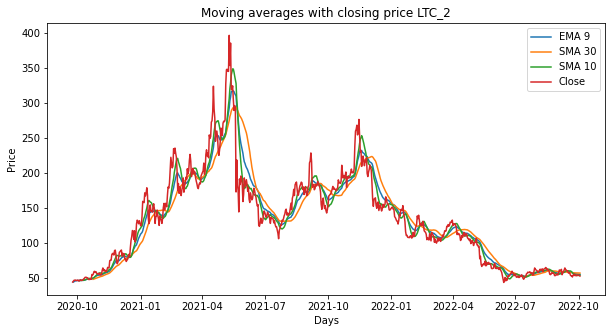

In [8]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(df.time_close, df.EMA_9, label='EMA 9')
plt.plot(df.time_close, df.SMA_30, label='SMA 30')
plt.plot(df.time_close, df.SMA_10, label='SMA 10')
plt.plot(df.time_close, df.close, label='Close')
plt.ylabel('Price')
plt.xlabel('Days')
plt.title('Moving averages with closing price LTC_2')
plt.legend()
plt.show()

In [9]:
def relative_strength_idx(df, n=14):
    close = df['close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi
df['RSI'] = relative_strength_idx(df).fillna(0)

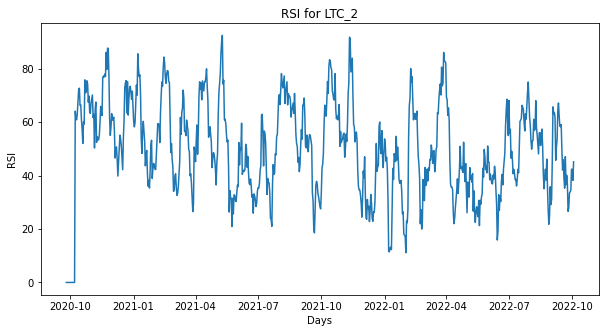

In [10]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(df.time_close, df.RSI)
plt.ylabel('RSI')
plt.xlabel('Days')
plt.title('RSI for LTC_2')
plt.show()

In [11]:
EMA_12 = pd.Series(df['close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

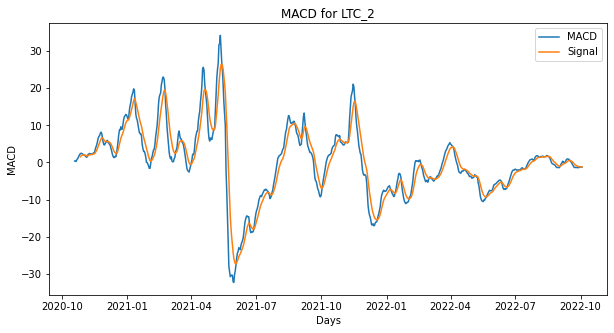

In [12]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(df.time_close, df.MACD, label='MACD')
plt.plot(df.time_close, df.MACD_signal, label='Signal')
plt.ylabel('MACD')
plt.xlabel('Days')
plt.title('MACD for LTC_2')
plt.legend()
plt.show()

In [13]:
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,time_close,close,volume,marketcap,month,day,weekday,day of week,price change,volume change,...,BTC_1,BTC_1 change,XMR_328,XMR_328 change,EMA_9,SMA_10,SMA_30,RSI,MACD,MACD_signal
0,2020-10-27,57.230768,3.661526e+09,3.762996e+09,10,27,1,1,-0.028926,-0.024228,...,13098.068382,0.003625,134.556445,0.021805,51.453524,51.769093,48.814861,67.465565,2.322216,1.552770
1,2020-10-28,58.362675,3.507820e+09,3.837731e+09,10,28,2,1,0.019778,-0.041979,...,13704.895178,0.046329,134.733687,0.001317,52.047776,52.760699,49.177882,69.757214,2.499150,1.764814
2,2020-10-29,55.833562,3.776423e+09,3.671716e+09,10,29,3,1,-0.043334,0.076573,...,13250.834371,-0.033131,126.596604,-0.060394,52.695479,53.875261,49.575478,63.630137,2.418586,1.907856
3,2020-10-30,55.539861,3.003985e+09,3.652735e+09,10,30,4,1,-0.005260,-0.204542,...,13570.470318,0.024122,124.943753,-0.013056,53.016520,54.732499,49.910108,63.272466,2.305548,1.993263
4,2020-10-31,54.657660,6.788779e+09,3.595100e+09,10,31,5,0,-0.015884,1.259925,...,13614.614949,0.003253,122.971292,-0.015787,53.274076,55.481676,50.241818,67.302290,2.123690,2.020866


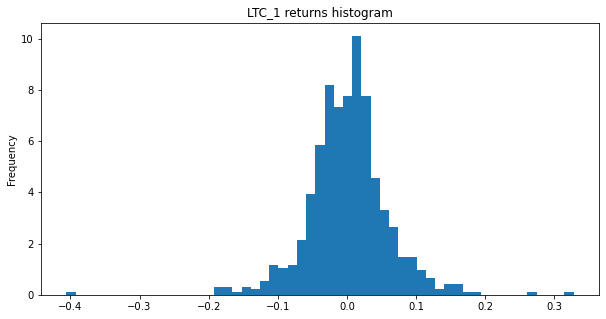

In [14]:
fig, ax = plt.subplots(figsize = (10, 5))
df['tomorrow change'].plot.hist(density=1, bins=55, ax=ax)
plt.title('LTC_1 returns histogram')
plt.show()

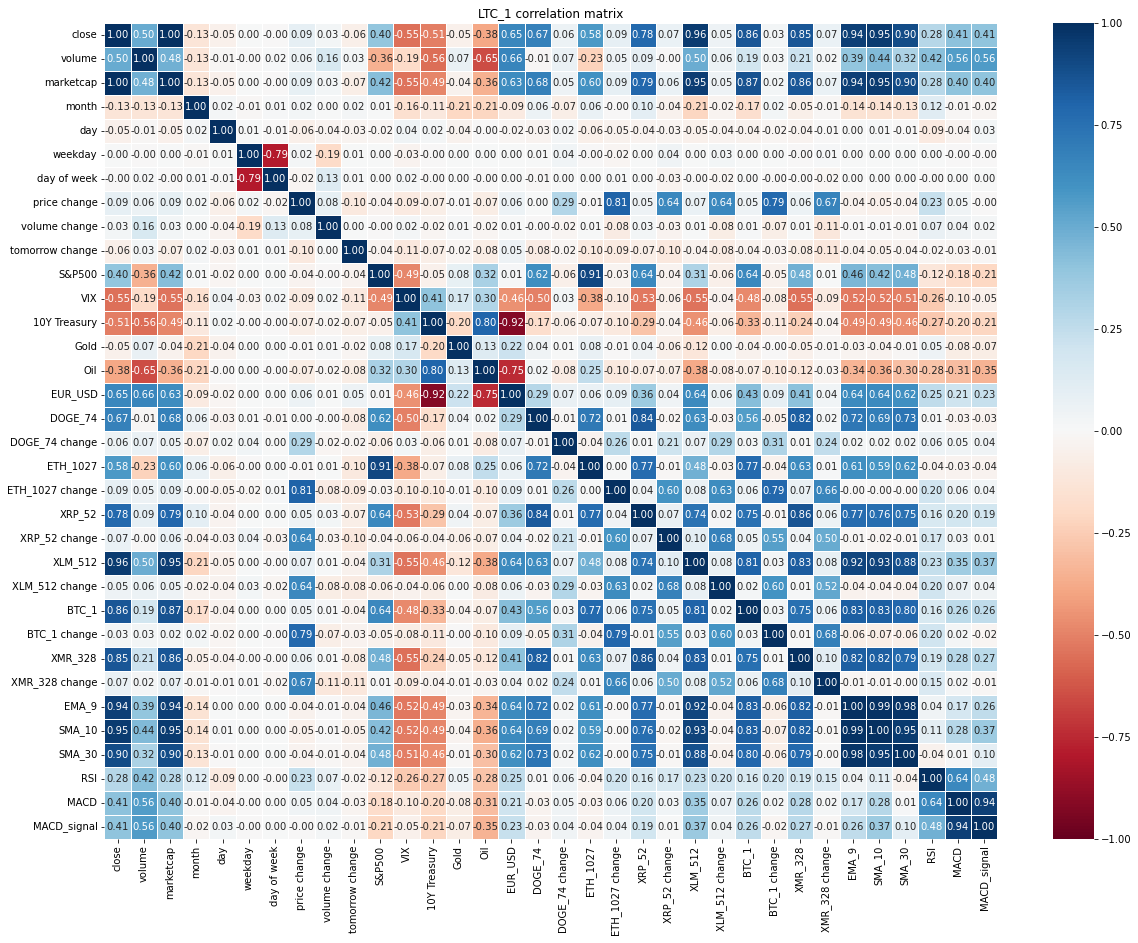

In [15]:
fig, ax = plt.subplots(figsize = (20, 15))
corrmat = df.drop(columns='time_close').corr()
sns.heatmap(corrmat, cmap="RdBu", linewidths=.5, vmin=-1, vmax=1, annot=True, fmt='.2f')
plt.title('LTC_1 correlation matrix')
plt.show()

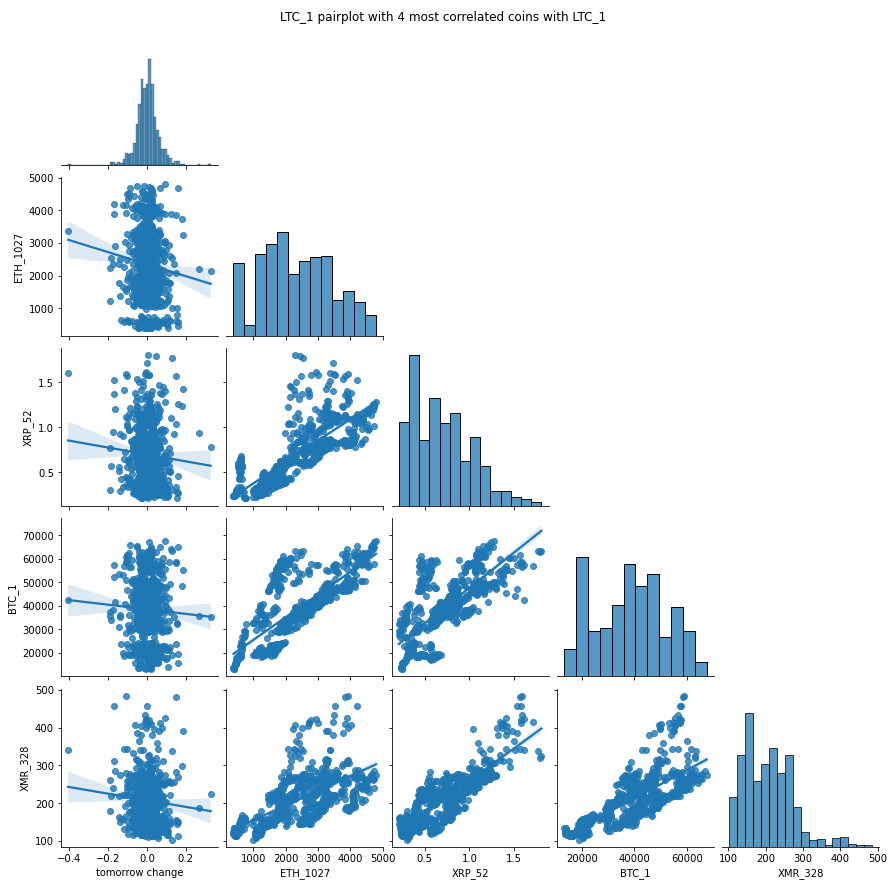

In [16]:
sns.pairplot(df[['tomorrow change', 'ETH_1027', 'XRP_52', 'BTC_1', 'XMR_328']], kind='reg', corner=True)
plt.suptitle('LTC_1 pairplot with 4 most correlated coins with LTC_1')
plt.show()

In [17]:
y = df[['tomorrow change', 'time_close', 'close']]
x = df.drop(columns=['tomorrow change'])

In [18]:
x_train = x.loc[x['time_close'] < '2022-09-03'].copy()
x_test = x.loc[x['time_close'] >= '2022-09-03'].copy()
y_train = y.loc[y['time_close'] < '2022-09-03'].copy()
y_test = y.loc[y['time_close'] >= '2022-09-03'].copy()

In [19]:
x_train.drop(columns='time_close', inplace = True)
x_test.drop(columns='time_close', inplace = True)

In [20]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = False)

In [21]:
# from sklearn.preprocessing import StandardScaler
# train_sc = StandardScaler()
# test_sc = StandardScaler()

# y_train['tomorrow change'] = train_sc.fit_transform(y_train['tomorrow change'].values.reshape(-1, 1))
# y_test['tomorrow change'] = test_sc.fit_transform(y_test['tomorrow change'].values.reshape(-1, 1))

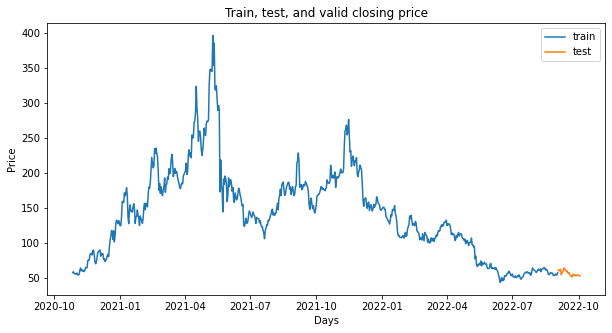

In [22]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(y_train.time_close, y_train.close, label='train')
plt.plot(y_test.time_close, y_test.close, label='test')
plt.ylabel('Price')
plt.xlabel('Days')
plt.title('Train, test, and valid closing price')
plt.legend()
plt.show()

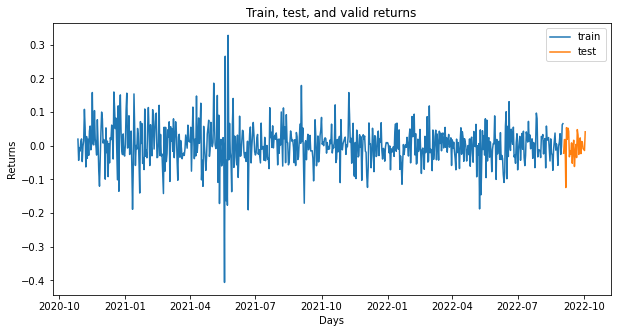

In [23]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(y_train.time_close, y_train['tomorrow change'], label='train')
plt.plot(y_test.time_close, y_test['tomorrow change'], label='test')
plt.ylabel('Returns')
plt.xlabel('Days')
plt.title('Train, test, and valid returns')
plt.legend()
plt.show()

In [24]:
train_dates = y_train['time_close'].values
test_dates = y_test['time_close'].values

y_train.drop(columns=['close', 'time_close'], inplace=True)
y_test.drop(columns=['close', 'time_close'], inplace=True)

In [25]:
param_grid = {'n_estimators':[5, 10, 25, 50, 75, 100]}

In [26]:
reg = lgb.LGBMRegressor()

In [27]:
grid = GridSearchCV(estimator = reg, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = 5, verbose = 1, return_train_score= True)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'n_estimators': [5, 10, 25, 50, 75, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

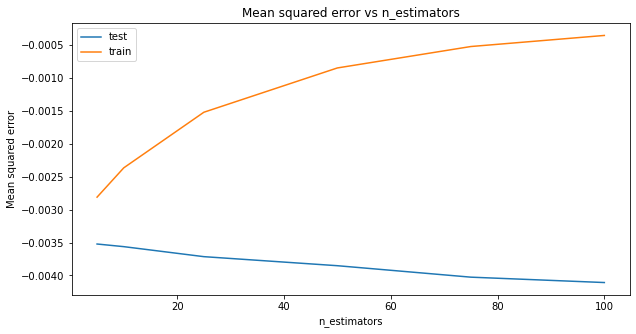

In [28]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(param_grid['n_estimators'], grid.cv_results_['mean_test_score'], label='test')
plt.plot(param_grid['n_estimators'], grid.cv_results_['mean_train_score'], label='train')
plt.ylabel('Mean squared error')
plt.xlabel('n_estimators')
plt.title('Mean squared error vs n_estimators')
plt.legend()
plt.show()

In [29]:
print(grid.best_params_)

{'n_estimators': 5}


In [30]:
# best_reg = lgb.LGBMRegressor(**grid.best_params_)
best_reg = lgb.LGBMRegressor(n_estimators = 100)
best_reg.fit(x_train, y_train)

LGBMRegressor()

In [31]:
pred = best_reg.predict(x_test)

In [32]:
mean_squared_error(y_test, pred)

0.0018406765623978575

In [33]:
mean_absolute_error(y_test, pred)

0.03166360690785967

In [34]:
r2_score(y_test, pred)

-0.34468465230400636

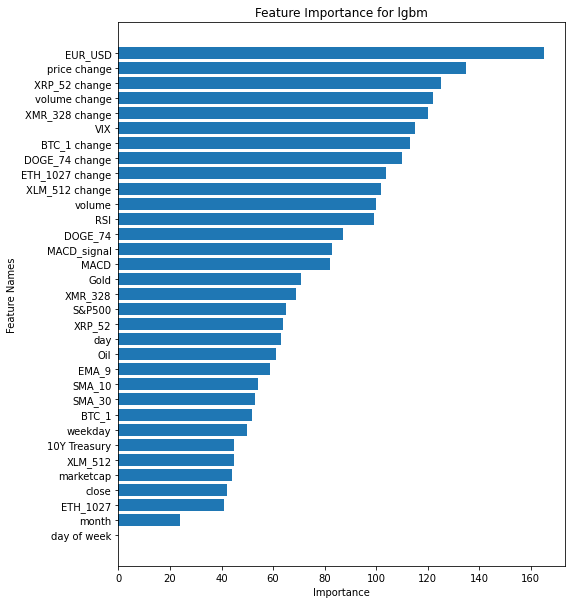

In [35]:
importance = best_reg.feature_importances_.copy()
sorted_import = importance.argsort()
fig, ax = plt.subplots(figsize = (8, 10))
plt.barh(x_train.columns[sorted_import], importance[sorted_import])
plt.xlabel('Importance')
plt.ylabel('Feature Names')
plt.title('Feature Importance for lgbm')
plt.show()

In [36]:
train_pred = best_reg.predict(x_train)
mean_squared_error(y_train, train_pred)

0.0003770174065172186

Text(0.5, 1.0, 'Training predicted returns vs actual')

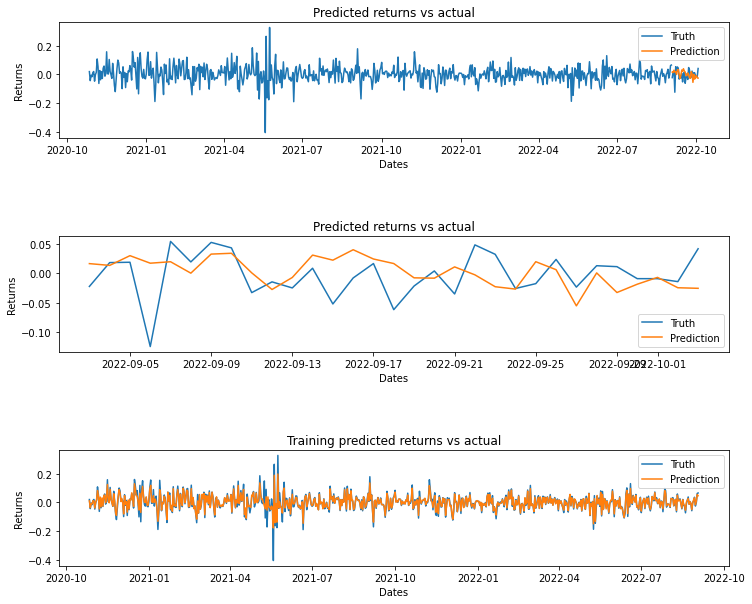

In [37]:
fig, ax = plt.subplots(nrows=3, ncols=1,figsize = (12, 10))
plt.subplots_adjust(hspace = 0.85)
ax[0].plot(train_dates, y_train['tomorrow change'], 'C0', label='Truth')
ax[0].plot(test_dates, y_test['tomorrow change'], 'C0')
ax[0].plot(test_dates, pred, 'C1', label='Prediction')
ax[0].legend()
ax[0].set_xlabel('Dates')
ax[0].set_ylabel('Returns')
ax[0].set_title('Predicted returns vs actual')

ax[1].plot(test_dates, y_test['tomorrow change'], 'C0', label='Truth')
ax[1].plot(test_dates, pred, 'C1', label='Prediction')
ax[1].legend()
ax[1].set_xlabel('Dates')
ax[1].set_ylabel('Returns')
ax[1].set_title('Predicted returns vs actual')

ax[2].plot(train_dates, y_train['tomorrow change'], 'C0', label='Truth')
ax[2].plot(train_dates, train_pred, 'C1', label='Prediction')
ax[2].legend()
ax[2].set_xlabel('Dates')
ax[2].set_ylabel('Returns')
ax[2].set_title('Training predicted returns vs actual')